# Setup environment

In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning')

    data_folder =  Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq
    !pip install torchinfo

else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    pass

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [2]:
# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = base_folder/'Custom_files' # Your Google Drive
    sys.path.append(str(custom_function_folder))
    model_folder = base_folder/'Models' # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = model_folder
    kaggle_api_folder = base_folder/'data/.kaggle'

# If running locally, specify a different path
else:
    pass

In [3]:
base_folder

PosixPath('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning')

# Importing libraries

In [4]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc
import pandas as pd

from data_module_fmnist import FashionMNISTDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from resnet import SimpleResNet
from shared_utils_fminst import plot_losses_acc

# Model initialisation

In [5]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=10)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 831914
Trainable parameters: 831914


# Transformation

In [6]:
trans_1 = transforms.ToTensor()

# Transform 2: Normalize the tensor images.
# The specified mean and standard deviation values are dataset-specific.
trans_2 = transforms.Normalize((0.2857,), (0.3528))

# Combine the above transformations into a single composite transform.
trans = transforms.Compose([trans_1, trans_2])

# Modules for training

In [7]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(num_classes=10)
    return model

In [8]:
def load_datamodule(config,data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    dm = FashionMNISTDataModule(
        data_dir=data_folder,
        train_transform=trans,
        test_transform=trans,
        **config['data_module']
    )
    return dm

In [9]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

In [10]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

In [11]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config, cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [12]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

In [13]:
# Load configurations from YAML files
project_folder = custom_function_folder
def load_all_configs():

    model_config = load_yaml(project_folder/'model_config_fminst.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config_fminst.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config_fminst.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

In [14]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [15]:
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
trainer_config

{'max_epochs': 2,
 'accelerator': 'auto',
 'devices': 'auto',
 'deterministic': False,
 'log_every_n_steps': 1,
 'gradient_clip_algorithm': 'norm',
 'gradient_clip_val': 0,
 'fast_dev_run': False,
 'overfit_batches': 0.0,
 'accumulate_grad_batches': 1,
 'limit_train_batches': 1.0,
 'limit_val_batches': 1.0,
 'limit_test_batches': 1.0}

In [16]:
cl_config

{'log_dir': 'logs',
 'lr_monitor': {'logging_interval': 'step'},
 'model_checkpoint': {'monitor': 'val_metric',
  'mode': 'max',
  'save_top_k': 1,
  'save_last': True},
 'early_stopping': {'monitor': 'val_metric',
  'patience': 5,
  'mode': 'max',
  'verbose': True},
 'wandb': {'project': 'FMINST', 'name': 'resnet'},
 'csv': {'name': 'csvlogger'}}

In [17]:
model_config

{'num_classes': 10}

# Running one batch to check for any errors

In [18]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run'] = True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
                                                       cl_config, batch_size=data_module_config['data_module']['batch_size'], logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


100%|██████████| 26421880/26421880 [00:01<00:00, 17009241.08it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 278093.88it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5101123.77it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21168899.01it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 831 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
831 K     Trainable params
0         Non-trainable params
831 K     Total params
3.328     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.29, Val_Metric: 0.14 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.60, Train_Metric: 0.08


# Learning rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.002154434690031884
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_fa97eb7d-5697-4b34-b0ee-69acf35b3001.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_fa97eb7d-5697-4b34-b0ee-69acf35b3001.ckpt


Train_Loss: 2.21, Train_Metric: 0.38
0.002154434690031884


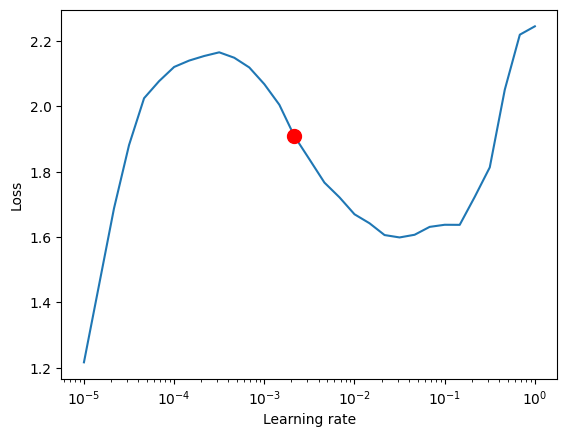

In [19]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs'] = 7
data_module_config['data_module']['batch_size'] = 32

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config,batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

# Model training

In [20]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size'] = 64
lightning_module_config['others']['learning_rate'] = 0.0021
trainer_config['max_epochs'] = 15
trainer_config['gradient_clip_val'] = 2
trainer_config['log_every_n_steps'] = 20

lightning_module_config['others']['optimizer_params']['weight_decay'] = 0.01
lightning_module_config['others']['learning_rate'] = 0.00215
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='fminst'
cl_config['wandb']['name']='resnet'

# data_module_config['data_module']['small_subset']=True
# data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup('fit')
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Models/logs exists and is no

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.35, Val_Metric: 0.87 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved. New best score: 0.870


Train_Loss: 0.43, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.33, Val_Metric: 0.88 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.008 >= min_delta = 0.0. New best score: 0.878


Train_Loss: 0.32, Train_Metric: 0.88
Epoch 00002: reducing learning rate of group 0 to 1.0750e-03.


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.28, Val_Metric: 0.90 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.020 >= min_delta = 0.0. New best score: 0.898


Train_Loss: 0.26, Train_Metric: 0.90
Epoch 00003: reducing learning rate of group 0 to 5.3750e-04.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.26, Val_Metric: 0.90 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.905


Train_Loss: 0.21, Train_Metric: 0.92
Epoch 00004: reducing learning rate of group 0 to 2.6875e-04.


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.907


Train_Loss: 0.18, Train_Metric: 0.93
Epoch 00005: reducing learning rate of group 0 to 1.3438e-04.


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.912


Train_Loss: 0.17, Train_Metric: 0.94
Epoch 00006: reducing learning rate of group 0 to 6.7188e-05.


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.913


Train_Loss: 0.15, Train_Metric: 0.94
Epoch 00007: reducing learning rate of group 0 to 3.3594e-05.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.000 >= min_delta = 0.0. New best score: 0.913


Train_Loss: 0.15, Train_Metric: 0.94
Epoch 00008: reducing learning rate of group 0 to 1.6797e-05.


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00009: reducing learning rate of group 0 to 8.3984e-06.


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00010: reducing learning rate of group 0 to 4.1992e-06.


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.000 >= min_delta = 0.0. New best score: 0.914


Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00011: reducing learning rate of group 0 to 2.0996e-06.


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00012: reducing learning rate of group 0 to 1.0498e-06.


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00013: reducing learning rate of group 0 to 5.2490e-07.


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.25, Val_Metric: 0.91 | Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00014: reducing learning rate of group 0 to 2.6245e-07.


Validation: 0it [00:00, ?it/s]

Epoch 15: Val_Loss: 0.25, Val_Metric: 0.91 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Train_Loss: 0.14, Train_Metric: 0.95
Epoch 00015: reducing learning rate of group 0 to 1.3123e-07.


In [21]:
file = f"{trainer.logger.log_dir}/metrics.csv"
print(file)

/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Models/logs/csvlogger/version_1/metrics.csv


In [22]:
df = pd.read_csv(file)
pd.DataFrame(df['val_metric'].dropna())

,val_metric
38,0.869917
79,0.877667
119,0.897833
160,0.904583
200,0.907417
241,0.912083
281,0.913083
322,0.913417
362,0.913250
403,0.912917


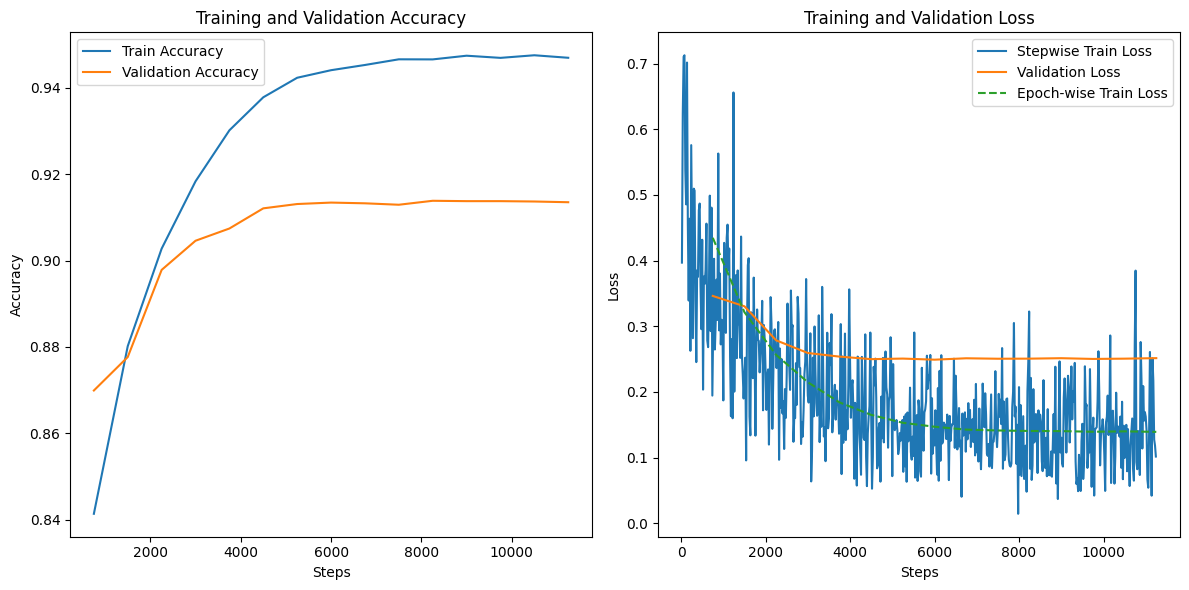

In [23]:
plot_losses_acc(file)